How have MLB Hall of Famer's Salaries changed over time? I will use Sean Lahman's Baseball Database to explore the following questions:

1. Has the pay of Hall of Famer's when adjusted for inflation increased over time?
2. How does the pay of Hall of Famer's evolve over their careers and has this changed over time?
3. Who is the highest paid Hall of Famer of all-time?
4. Who is the lowest paid Hall of Famer of all-time?

## 1. Has the pay of Hall of Famer's when adjusted for inflation increased over time?

The Lahman database only has salary dating back to the 70s but baseball-reference.com has much more. I obtained this data for a whole bunch of players. Here's what it looks like:

In [1]:
import pandas as pd
import numpy as np

In [2]:
salaries = pd.read_csv('./../data/Salaries/salary.csv')

In [3]:
salaries.head()

,bbrefID,Year,Tm,Salary
0,aardsda01,2004.0,SFG,"$300,000"
1,aardsda01,2006.0,CHC,NaN
2,aardsda01,2007.0,CHW,"$387,500"
3,aardsda01,2008.0,BOS,"$403,250"
4,aardsda01,2009.0,SEA,"$419,000"


In [4]:
salaries.shape

(144867, 4)

How many unique players?

In [5]:
len(salaries.bbrefID.unique())

17812

Now let's establish a connection to the Lahman Database. I have this database loaded into a psql database on an AWS instance. I'll connect to it here.

In [6]:
from sqlalchemy import create_engine
import getpass

In [7]:
passw = getpass.getpass("Password Please: ")

Password Please: ········


In [8]:
cnx = create_engine('postgresql://adam:%s@52.23.226.111:5432/baseball'%passw)

Here are the tables in the database:

In [9]:
print ', '.join(pd.read_sql_query("select table_name from information_schema.tables where table_schema = 'public';"
                                  ,cnx).table_name.tolist())

fielding, all_star, appearances, manager_award, player_award, manager_award_vote, player_award_vote, batting, batting_postseason, player_college, fielding_outfield, fielding_postseason, hall_of_fame, home_game, manager, manager_half, player, park, pitching, college, pitching_postseason, postseason, salary, team, team_franchise, team_half


Let's take a look at the hall of fame table.

In [10]:
hall_of_fame = pd.read_sql_query('select * from hall_of_fame;',cnx)

In [11]:
hall_of_fame.head()

,player_id,yearid,votedby,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,None
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,None
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,None
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,None
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,None


In [12]:
hall_of_fame.votedby.value_counts()

BBWAA               3689
Veterans             189
Run Off               81
Nominating Vote       76
Old Timers            30
Negro League          26
Final Ballot          21
Centennial             6
Special Election       2
Name: votedby, dtype: int64

In [13]:
hall_of_fame.category.value_counts()

Player               3997
Manager                74
Pioneer/Executive      39
Umpire                 10
Name: category, dtype: int64

I'll only consider Players. Also, I'll exclude players from the Negro League since I do not have salary data on them.

I'll make a python set of all the player ids of these hall of famers.

In [14]:
hall = set(hall_of_fame[(hall_of_fame.inducted=='Y') & 
                        (hall_of_fame.category=='Player') & 
                        (hall_of_fame.votedby!='Negro League')].player_id)
hall.discard(u'griffcl01') ## he was not inducted as a player: http://www.baseball-reference.com/players/g/griffcl01.shtml

In [15]:
len(hall)

225

Now let's filter the salary table to just Hall of Famers. We need to first match the bbref IDs to the player_id that the Lahman database uses.

In [16]:
player = pd.read_sql_query('select * from player;',cnx)

In [17]:
bbid_to_pid = {b:p for b,p in zip(player.bbref_id,player.player_id)}
pid_to_name = {p:(fn,ln) for p,fn,ln in zip(player.player_id,player.name_first,player.name_last)}

In [18]:
salaries.insert(0,'player_id',[bbid_to_pid[bbid] for bbid in salaries.bbrefID])

In [19]:
salaries = salaries[salaries.player_id.isin(hall)].reset_index(drop=True)

In [20]:
salaries.head(3)

,player_id,bbrefID,Year,Tm,Salary
0,aaronha01,aaronha01,1954.0,MLN,"$6,000"
1,aaronha01,aaronha01,1955.0,MLN,"$10,000"
2,aaronha01,aaronha01,1956.0,MLN,"$17,500"


In [21]:
salaries.shape

(5322, 5)

Let's see if we have data on all 225 hall of famers..

In [22]:
len(salaries.player_id.unique())

217

Ok, that's not bad. Let's see how many null values there are for salary.

In [23]:
sum(salaries.Salary.isnull())

2171

Yikes, that's a lot. We'll have to figure out a smart way to deal with that.

Let's see some of the oldest data.

In [24]:
salaries.sort_values('Year').head(7)

,player_id,bbrefID,Year,Tm,Salary
3778,whitede01,whitede01,1871.0,CLE,NaN
63,ansonca01,ansonca01,1871.0,ROK,NaN
2677,orourji01,o'rouji01,1872.0,MAN,NaN
3779,whitede01,whitede01,1872.0,CLE,NaN
64,ansonca01,ansonca01,1872.0,ATH,NaN
2678,orourji01,o'rouji01,1873.0,BOS,$800
3780,whitede01,whitede01,1873.0,BOS,"$1,500"


Some of the null value are a result of the fact that the years in which a player played on multiple teams have null values for one of the entries. After converting Salary to a number, I'll group by player_id and Year and see how many truely missing Salary entires we have.

In [25]:
salaries.Salary = pd.to_numeric(salaries.Salary.str.replace('$','').str.replace(',',''))
salaries.Year = salaries.Year.astype(int)

In [26]:
salaries.head(3)

,player_id,bbrefID,Year,Tm,Salary
0,aaronha01,aaronha01,1954,MLN,6000.0
1,aaronha01,aaronha01,1955,MLN,10000.0
2,aaronha01,aaronha01,1956,MLN,17500.0


In [27]:
unique_player_years = salaries.groupby(['player_id','Year']).sum().shape[0]
null_player_years = sum(salaries.groupby(['player_id','Year']).sum().Salary.isnull())

In [28]:
print unique_player_years, null_player_years, float(null_player_years)/unique_player_years

3873 1509 0.389620449264


Still 39% of the data is missing. Eventually I will impute this data and try to do it in a way that makes sense. First, let's start visualizing the data a little bit. Let's aggregate the mean salary by year.

In [29]:
counts = salaries.dropna().groupby('Year',as_index=False).count()[['Year','Salary']]

In [30]:
counts.head(5)

,Year,Salary
0,1873,2
1,1874,2
2,1879,1
3,1880,3
4,1881,12


In [31]:
counts.tail(3)

,Year,Salary
129,2008,12
130,2009,5
131,2010,1


Too avoid getting too noisy of a picture, I'm going to restrict the mean salaries to only years when we have at least 4 players' salaries.

In [32]:
mean_salaries = salaries.dropna().groupby('Year',as_index=False).mean()[counts.Salary>3]

In [33]:
mean_salaries.head(3)

,Year,Salary
4,1881,1372.916667
5,1882,1553.846154
6,1883,2164.705882


I'll plot the average HOF salary across time. Actually, I'll plot the log of salary since that will make it easier to visualize.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

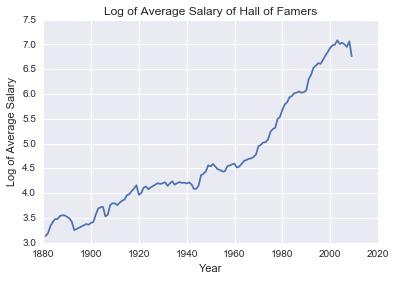

In [35]:
plt.plot(mean_salaries.Year,np.log10(mean_salaries.Salary));
plt.xlabel('Year');
plt.ylabel('Log of Average Salary');
plt.title('Log of Average Salary of Hall of Famers');

Ok, this is to be expected, the average salary has been increasing through time. Cool to see that the average salary did not rise from about 1926 to about 1940 and then dropped around World War 2 as this corresponds to expectations.

Let's plot this next to the Consumer Price Index to see it in some context. Since the CPI did not start officially being tracked until 1913, I obtained some CPI data from [here](http://www.econ.yale.edu/~shiller/data.htm). This is data used by Robert Sciller in *Irrational Exuberance*. It happens to start exactly in 1871 which is the first year of MLB. I'll read this in and then do the necessary steps to get it plotted next to the Average Salary.

In [36]:
cpi = pd.read_csv('./../data/Salaries/ie_data.csv')[['Date','CPI']]

In [37]:
cpi.head(3)

,Date,CPI
0,1871.01,12.46
1,1871.02,12.84
2,1871.03,13.03


I'll just use April of every year as I don't need month by month data.

In [38]:
cpi = cpi[cpi.Date.astype(str).str.endswith('03')].reset_index(drop=True)
cpi.Date = cpi.Date.astype(int)
cpi.columns = ['Year','CPI']

In [39]:
cpi.head(3)

,Year,CPI
0,1871,13.03
1,1872,12.84
2,1873,13.23


Now I want to see how much the salary of a base year compares to the rest of the years if we adjust for inflation. I'll use 1881 as a base year for now since it is the first year we have non-null data for. I'll calculate how much 1372 dollars in 1873 corresponds to in all the rest of the years. Then I'll plot the result.

In [40]:
cpi.insert(len(cpi.columns),'Base-1881',cpi.CPI.values/cpi[cpi.Year==1881].CPI.values)

In [41]:
cpi.head(4)

,Year,CPI,Base-1881
0,1871,13.03,1.370137
1,1872,12.84,1.350158
2,1873,13.23,1.391167
3,1874,12.37,1.300736


In [42]:
adjusted_base_salary = pd.merge(cpi,mean_salaries,on='Year')
adjusted_base_salary['1881_Salary_Adjusted'] = adjusted_base_salary.iloc[0].Salary*adjusted_base_salary['Base-1881']

In [43]:
adjusted_base_salary.head(4)

,Year,CPI,Base-1881,Salary,1881_Salary_Adjusted
0,1881,9.51,1.000000,1372.916667,1372.916667
1,1882,10.28,1.080967,1553.846154,1484.078163
2,1883,9.99,1.050473,2164.705882,1442.212145
3,1884,9.23,0.970557,2610.526316,1332.494304


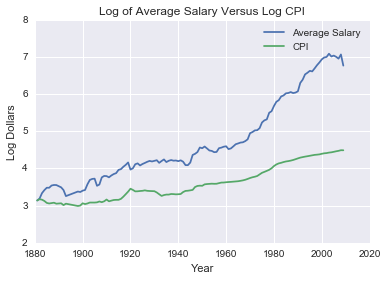

In [44]:
plt.plot(adjusted_base_salary.Year,np.log10(adjusted_base_salary.Salary),label='Average Salary');
plt.plot(adjusted_base_salary.Year,np.log10(adjusted_base_salary['1881_Salary_Adjusted']),label='CPI');
plt.plot()
plt.xlabel('Year');
plt.ylabel('Log Dollars');
plt.title('Log of Average Salary Versus Log CPI');
plt.legend();

Ok, so we can see quite clearly that the average salary of hall of famers has outpaced the rate of inflation. Let's see this one other way. Let's put all the average salaries in 2009 dollars (the last year in this data) and then plot the average through time.

In [45]:
adjusted_base_salary.insert(3,'Base-2009',adjusted_base_salary.iloc[-1].CPI/adjusted_base_salary.CPI)

In [46]:
adjusted_base_salary.head(2)

,Year,CPI,Base-1881,Base-2009,Salary,1881_Salary_Adjusted
0,1881,9.51,1.000000,22.366877,1372.916667,1372.916667
1,1882,10.28,1.080967,20.691537,1553.846154,1484.078163


In [47]:
adjusted_base_salary['Salary_in_2009_dollars'] = adjusted_base_salary.Salary * adjusted_base_salary['Base-2009']

In [48]:
adjusted_base_salary.head(2)

,Year,CPI,Base-1881,Base-2009,Salary,1881_Salary_Adjusted,Salary_in_2009_dollars
0,1881,9.51,1.000000,22.366877,1372.916667,1372.916667,30707.858176
1,1882,10.28,1.080967,20.691537,1553.846154,1484.078163,32151.465130


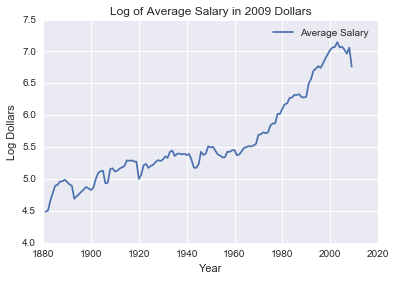

In [49]:
plt.plot(adjusted_base_salary.Year,np.log10(adjusted_base_salary.Salary_in_2009_dollars),label='Average Salary');
plt.plot()
plt.xlabel('Year');
plt.ylabel('Log Dollars');
plt.title('Log of Average Salary in 2009 Dollars');
plt.legend();

Since log10 of 10 million is 7, this coresponds to hall-of-famers making around 10 million on average throughout their careers in the mid 2000s. Back before the turn of the century, hall-of-fame players were only making bettween 30 and 100 thousand dollars in 2009 dollars.

Salaries have increased tremndously over the past 40 years. Hall of fame caliber players are now averaging 10 times more per year over the course of their careers than Hank Aaron made at the peak of his earning power.

I feel as though I have satisfactorily answered the first of my four driving questions. Now on to the rest. 

## 2. How does the pay of Hall of Famer's evolve over their carrers and has this changed over time?



We would like to impute data that is missing. Here's my plan for doing so. We use the ratios of all players' earnings in the time series that is their careers and then use this average career earnings trajectory to imput missing data.

Because the common career trajectory might be changing through time, I'll bin the data into 6 bins like this:

1. 1871-1899
2. 1900-1919
3. 1920-1939
4. 1940-1959
5. 1960-1979
6. 1980-2010

First, we will have to drop the players who have all missing values for their salaries since we have no info on them.

In [50]:
players_to_drop = salaries.groupby('player_id',as_index=False).count()['player_id'][(salaries.groupby('player_id').count().Salary==0).values]

In [51]:
players_to_drop

33     chancfr01
85     hafeych01
98     jackstr01
109    kellyge01
119    lindsfr01
133    mccarto01
158     ricesa01
Name: player_id, dtype: object

In [52]:
salaries = salaries[~salaries.player_id.isin(players_to_drop)].reset_index(drop=True)

First let me insert a column for year of the career and adjust all the salaries for inflation.

In [53]:
salaries.insert(3,'Year_of_career',np.zeros(len(salaries)))
for bbref in pd.unique(salaries.bbrefID):
    salaries.ix[salaries.bbrefID==bbref,'Year_of_career'] = range(1,sum(salaries.bbrefID==bbref)+1)

In [54]:
cpi.insert(len(cpi.columns),'Base-2010',cpi[cpi.Year==2010].CPI.values/cpi.CPI.values)

In [55]:
year_to_base_2010 = {y:b for y,b in zip(cpi.Year,cpi['Base-2010'])}

In [56]:
salaries.insert(len(salaries.columns),'Salary-2010',[year_to_base_2010[y]*s for y,s in zip(salaries.Year,salaries.Salary)])

In [57]:
salaries.head(3)

,player_id,bbrefID,Year,Year_of_career,Tm,Salary,Salary-2010
0,aaronha01,aaronha01,1954,1.0,MLN,6000.0,48542.230483
1,aaronha01,aaronha01,1955,2.0,MLN,10000.0,81509.737828
2,aaronha01,aaronha01,1956,3.0,MLN,17500.0,142109.794776


Now I'm going to drop the duplicates of player-Year combinations. I need to make sure to drop only the null row and not the non null row so first I'll sort by player-Year-Salary and then I'll drop the duplicates.

In [58]:
salaries = salaries.sort_values(['player_id','Year','Salary'])
salaries = salaries.drop_duplicates(subset=['player_id','Year'],keep='first')

Now I'm going to calculate the ratio of first year salary to the rest of the year's salaries across all players for which the first year's salary is available.

In [59]:
max_seasons = salaries.Year_of_career.max().astype(int)
A = pd.DataFrame({'%d' % i : [[] for _ in range(max_seasons)] for i in range(1,max_seasons+1)})[['%d' % i for i in range(1,max_seasons+1)]]
for player_id,df in salaries.groupby('player_id'):
    for year1 in df.Year_of_career:
        for year2 in df.Year_of_career:
            ratio = df[df.Year_of_career==year1]['Salary-2010'].values/df[df.Year_of_career==year2]['Salary-2010'].values
            if np.isnan(ratio):
                continue
            A.iloc[int(year1)-1,int(year2)-1].append(ratio[0])

Time to plot the data.

In [60]:
x,y,w = [],[],[]
for u,arr in enumerate(A['1']):
    if len(arr)<=3:
        continue
    else:
        x.append(u+1)
        y.append(np.mean(arr))
        w.append(1/np.std(arr) if np.std(arr)!=0 else 1)

In [61]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [62]:
s = InterpolatedUnivariateSpline(x, y, w, k=1)

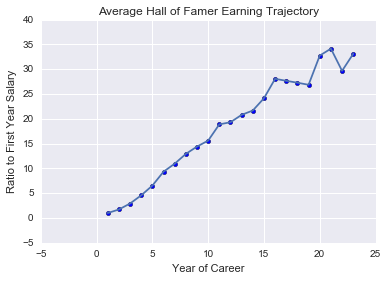

In [63]:
plt.scatter(x,y);
plt.plot(x,s(x));
plt.title('Average Hall of Famer Earning Trajectory')
plt.xlabel('Year of Career')
plt.ylabel('Ratio to First Year Salary');

Now I'll use this average trajectory to impute all the missing salary data. I'll use all the available year's data on a players salary to do this by imputing what the salary would be with each point and then taking the average across all points.

In [64]:
for player_id,df in salaries.groupby('player_id'):
    for year1 in df.Year_of_career:
        if np.isnan(df[df.Year_of_career==year1]['Salary-2010'].values[0]):
            impute = []
            for year2 in df.Year_of_career:
                if np.isnan(df[df.Year_of_career==year2]['Salary-2010'].values[0]):
                    continue
                else:
                    impute.append(s(year1)/s(year2) * df[df.Year_of_career==year2]['Salary-2010'].values[0])
            salaries.loc[(salaries.player_id==player_id) & (salaries.Year_of_career==year1),'Salary-2010'] = np.mean(impute)       

In [65]:
sum(salaries['Salary-2010'].isnull())

0

Yay! No more nulls. Now let's bin the data into our 6 bins then visualize the career earning trajectories for each of the bins.

In [66]:
salaries.insert(len(salaries.columns),'Bin_1',salaries.Year<1900)
salaries.insert(len(salaries.columns),'Bin_2',np.logical_and(salaries.Year>=1900,salaries.Year<1920))
salaries.insert(len(salaries.columns),'Bin_3',np.logical_and(salaries.Year>=1920,salaries.Year<1940))
salaries.insert(len(salaries.columns),'Bin_4',np.logical_and(salaries.Year>=1940,salaries.Year<1960))
salaries.insert(len(salaries.columns),'Bin_5',np.logical_and(salaries.Year>=1960,salaries.Year<1980))
salaries.insert(len(salaries.columns),'Bin_6',salaries.Year>1980)

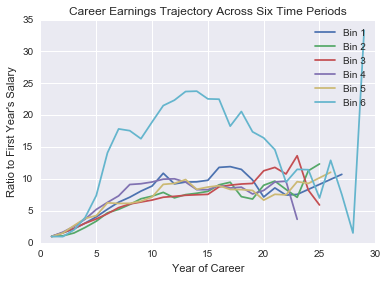

In [67]:
for b in range(1,7):
    base_salary = salaries[salaries['Bin_%d' % b]].groupby('Year_of_career',as_index=False).mean().iloc[0]['Salary-2010']
    x = salaries[salaries['Bin_%d' % b]].groupby('Year_of_career',as_index=False).mean().Year_of_career
    y = salaries[salaries['Bin_%d' % b]].groupby('Year_of_career',as_index=False).mean()['Salary-2010']/base_salary
    plt.plot(x,y,label='Bin %d' % b)
plt.legend();
plt.xlabel('Year of Career')
plt.ylabel("Ratio to First Year's Salary")
plt.title('Career Earnings Trajectory Across Six Time Periods');

So not only are Hall of Famers making more money than ever, the ratio of their salary during the peak of their careers to their rookie salary is higher as well.

## 3. Who is the highest paid Hall of Famer of all-time?

Who is the highest paid hall of famer of all-time. Well if what I've seen so far has taught me anything, it's that the pay of hall of famers has changed substantially throughout the history of baseball. How to answer this question can definetly by debated but I think that players should be compared to their peers to control for aspects of the game changing through time.

To answer this question I will look at two metrics:
* highest single season of pay
* highest average pay

I will take a nearest neighbor approach to this question. My X will have two features - year started career and year ended career. For each player I'll find his k nearest neighbors and compare their average metrics to the player's highest metric. The players with the highest differences I'll determine to be the highest paid players.

First I'll make a nice dataframe with player_id, first season of career, last season of career, highest single season pay and average pay. 

In [68]:
first_season = {pl:yr for pl,yr in zip(salaries.groupby('player_id').min()['Year'].index,
                                  salaries.groupby('player_id').min()['Year'])}
last_season = {pl:yr for pl,yr in zip(salaries.groupby('player_id').max()['Year'].index,
                                  salaries.groupby('player_id').max()['Year'])}
highest_season_pay = {pl:pa for pl,pa in zip(salaries.groupby('player_id').max()['Salary-2010'].index,
                                  salaries.groupby('player_id').max()['Salary-2010'])}
ave_pay = {pl:pa for pl,pa in zip(salaries.groupby('player_id').mean()['Salary-2010'].index,
                                  salaries.groupby('player_id').mean()['Salary-2010'])}

In [69]:
salaries_new = pd.DataFrame({'player_id':pd.unique(salaries.player_id),
                             'first_season':[first_season[p] for p in pd.unique(salaries.player_id)],
                             'last_season':[last_season[p] for p in pd.unique(salaries.player_id)],
                             'highest_season_pay':[highest_season_pay[p] for p in pd.unique(salaries.player_id)],
                             'ave_pay':[ave_pay[p] for p in pd.unique(salaries.player_id)]})
salaries_new = salaries_new[['player_id','first_season','last_season','highest_season_pay','ave_pay']]

In [70]:
salaries_new.head(3)

,player_id,first_season,last_season,highest_season_pay,ave_pay
0,aaronha01,1954,1976,1.051357e+06,5.106484e+05
1,alexape01,1911,1930,6.500415e+05,2.743846e+05
2,alomaro01,1988,2004,9.663965e+06,6.038156e+06


Let's try k equals 8 nearest neighbors first.

In [71]:
from sklearn.neighbors import KNeighborsRegressor

In [72]:
knn = KNeighborsRegressor(n_neighbors=8, weights='uniform')
d_larg = {}
for player_id in pd.unique(salaries_new.player_id):
    X = salaries_new[salaries_new.player_id!=player_id].iloc[:,1:3].values
    y = salaries_new[salaries_new.player_id!=player_id].iloc[:,-2]
    knn.fit(X,y)
    d_larg[player_id] = (salaries_new[salaries_new.player_id==player_id].iloc[:,-2].values - \
                    knn.predict(salaries_new[salaries_new.player_id==player_id].iloc[:,1:3].values))[0]

Top 5 Players:

In [73]:
for key in sorted(d_larg,key=d_larg.get,reverse=True)[:5]:
    print key,' '.join(pid_to_name[key]),d_larg[key]

martipe02 Pedro Martinez 5110854.53332
piazzmi01 Mike Piazza 4214833.04228
maddugr01 Greg Maddux 4128668.5463
ryanno01 Nolan Ryan 3459037.38655
johnsra05 Randy Johnson 3151130.34709


Let's try k equals 12 also.

In [74]:
knn = KNeighborsRegressor(n_neighbors=12, weights='uniform')
d_larg = {}
for player_id in pd.unique(salaries_new.player_id):
    X = salaries_new[salaries_new.player_id!=player_id].iloc[:,1:3].values
    y = salaries_new[salaries_new.player_id!=player_id].iloc[:,-2]
    knn.fit(X,y)
    d_larg[player_id] = (salaries_new[salaries_new.player_id==player_id].iloc[:,-2].values - \
                    knn.predict(salaries_new[salaries_new.player_id==player_id].iloc[:,1:3].values))[0]

In [75]:
for key in sorted(d_larg,key=d_larg.get,reverse=True)[:5]:
    print key,' '.join(pid_to_name[key]),d_larg[key]

martipe02 Pedro Martinez 6979943.9796
piazzmi01 Mike Piazza 5182666.60548
johnsra05 Randy Johnson 5092802.17064
maddugr01 Greg Maddux 3878006.34649
ryanno01 Nolan Ryan 3404482.70459


Seems pretty robust to the choice of K. This metric really favors pitchers. Let's see the average pay metric. Let's just try k = 12 this time.

In [76]:
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform')
d_ave = {}
for player_id in pd.unique(salaries_new.player_id):
    X = salaries_new[salaries_new.player_id!=player_id].iloc[:,1:3].values
    y = salaries_new[salaries_new.player_id!=player_id].iloc[:,-1]
    knn.fit(X,y)
    d_ave[player_id] = (salaries_new[salaries_new.player_id==player_id].iloc[:,-1].values - \
                    knn.predict(salaries_new[salaries_new.player_id==player_id].iloc[:,1:3].values))[0]

In [77]:
for key in sorted(d_ave,key=d_ave.get,reverse=True)[:5]:
    print key,' '.join(pid_to_name[key]),d_ave[key]

martipe02 Pedro Martinez 3154240.74235
johnsra05 Randy Johnson 2084458.68497
ripkeca01 Cal Ripken 1674843.44608
piazzmi01 Mike Piazza 1620561.59522
griffke02 Ken Griffey 900153.228145


According to this analysis, Pedro Martinez is the highest paid Hall of Famer of all time.

## 4. Who is the lowest paid Hall of Famer of all-time?

I'll conclude by showing the lowest paid Hall of Famer of all-time by both metrics. I'll keep K fixed at 10 for brevity's sake.

In [78]:
for key in sorted(d_larg,key=d_larg.get)[:5]:
    print key,' '.join(pid_to_name[key]),d_larg[key]

alomaro01 Roberto Alomar -4567414.59339
biggicr01 Craig Biggio -2557191.25365
larkiba01 Barry Larkin -1866460.40431
smithoz01 Ozzie Smith -1828868.42516
gossari01 Rich Gossage -1547158.65891


In [79]:
for key in sorted(d_ave,key=d_ave.get)[:5]:
    print key,' '.join(pid_to_name[key]),d_ave[key]

biggicr01 Craig Biggio -2703609.52425
alomaro01 Roberto Alomar -1840249.8082
thomafr04 Frank Thomas -779968.217191
gossari01 Rich Gossage -739228.90022
larkiba01 Barry Larkin -656353.289432


According to this analysis, either Craig Biggio or Roberto Alomar is the lowest paid Hall of Famer of all time, depending on your definition.